In [27]:
import warnings
from typing import Callable, Dict, Optional, Tuple, Type, Union
import numpy as np
import jax
import math
from jax import jit, vmap
import jaxlib
import jax.numpy as jnp
import jax.random as jra
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tqdm as notebook_tqdm

from numpyro_models import Exact_tGP, get_keys

In [28]:
data = np.loadtxt("data/P3HT_dataset.csv", delimiter=",", skiprows=1)

X = np.array(data[:, 0:-1], dtype=np.double)
y = np.array(data[:, -1], dtype=np.double).flatten()

# min max scale the X vals, assume we know the bounds ahead of time.
normalizer = MinMaxScaler()
X = normalizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

In [29]:
np.random.seed(42)
real_std = 0.1
X = np.linspace(0.0, np.pi * 2, 100)[:, None]
Y = np.sin(X) + np.random.randn(*X.shape) * real_std
Y = Y / Y.max()
Yc = Y.copy() # Corrupted data
X = X/X.max()
# Slightly noisy data
Yc[75:79] += 1.0

normalizer = MinMaxScaler()
X_train = normalizer.fit_transform(X)

scaler = StandardScaler()
y_train = scaler.fit_transform(Yc).flatten()

X_test = np.linspace(0.01, 0.99, 200)[:, None]

In [30]:
rng_key, rng_key_predict = get_keys()
tGP = Exact_tGP(input_dim=X_train.shape[1])
tGP.fit(rng_key, X_train, y_train, num_warmup=5000, num_samples=5000, num_chains=1)
means, samples = tGP.predict(rng_key_predict, X_test)

sample: 100%|██████████| 10000/10000 [23:39<00:00,  7.04it/s, 503 steps of size 1.12e-02. acc. prob=0.87]



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
              f[0]      0.06      0.07      0.05     -0.05      0.17   3353.89      1.00
              f[1]      0.13      0.06      0.13      0.04      0.23   3368.68      1.00
              f[2]      0.21      0.05      0.21      0.13      0.30   3325.82      1.00
              f[3]      0.28      0.05      0.28      0.21      0.36   3206.14      1.00
              f[4]      0.36      0.04      0.36      0.29      0.43   3060.72      1.00
              f[5]      0.44      0.04      0.43      0.37      0.50   2891.03      1.00
              f[6]      0.51      0.04      0.51      0.45      0.57   2737.80      1.00
              f[7]      0.58      0.04      0.58      0.52      0.65   2626.57      1.00
              f[8]      0.66      0.04      0.66      0.59      0.72   2540.55      1.00
              f[9]      0.73      0.04      0.73      0.67      0.79   2472.59      1.00
             f[10]  

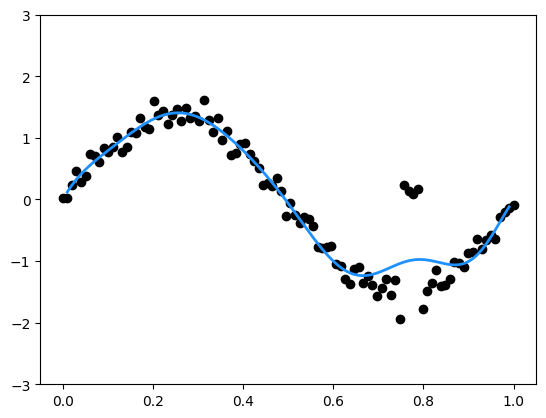

In [36]:
import matplotlib.pyplot as plt

plt.scatter(X_train, y_train, color='black')
plt.plot(X_test, np.mean(means, axis=0), color='dodgerblue', lw=2)
# plt.plot(X_test, samples.T, color='dodgerblue', lw=2, alpha=0.01)
plt.ylim(-3, 3)
plt.show()

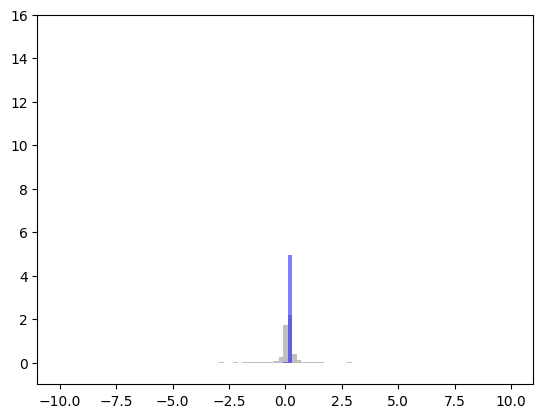

In [44]:
mean = means[:,0]
sample = samples[:,0]

bins = np.linspace(-10, 10, 100)

plt.hist(sample, bins=bins, alpha=0.5, label="samples", density=True, color='grey')
plt.hist(mean, bins=bins, alpha=0.5, label="mean", density=True, color='blue')
# plt.axvline(x=y_test[0], color='r', linestyle='dashed', linewidth=2, label="true")
plt.ylim(-1, 16)
plt.show()